In [7]:
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd

import wows_shell

with open('current_lgb.json') as f:
    lgd_shell_data = json.load(f)

gp_ship_local_ship = {}
shells_ship_artillery = defaultdict(lambda: defaultdict(list))
for __nation, nation_data in lgd_shell_data['ships'].items():
    for __type, type_data in nation_data.items():
        for gp_ship, ship_data in type_data.items():
            gp_ship_local_ship[gp_ship] = ship_data['Name']

            org_artilleries = ship_data['artillery']
            for artillery, artillery_data in org_artilleries.items():
                for shell_type, shell_name in artillery_data['shells'].items():
                    if shell_type == 'AP':
                        shells_ship_artillery[shell_name][gp_ship].append(artillery)

ap_shells = {}
for shell, shell_data in lgd_shell_data['shells'].items():
    if shell_data['alphaPiercingHE'] == 0 and shell_data['alphaPiercingCS'] == 0:
        ap_shells[shell] = shell_data


#print(ap_shells.keys())
#print(ap_shells['PAPA001_Shell_203mm_AP_AP_Mk_19'])

#print(shells_ship_artillery)


In [8]:
test_distances = [d*1000 for d in range(0, 35, 5)]
print(test_distances)

[0, 5000, 10000, 15000, 20000, 25000, 30000]


In [9]:
shell_difference = {
    'shell': [],
    'test_distance': [],
    'difference': [],
}
shell_impact_data = {}

def old_penetration (krupp, mass, caliber, normalization, impact_speed, impact_angle):
    raw = krupp / 2400 * impact_speed ** 1.4822064892953855 * mass ** 0.5506 * caliber ** -0.6521 * 0.00046905491615181766 
    angle = raw * np.cos(impact_angle)
    normalization_rad = np.deg2rad(normalization)
    normalized = raw * np.cos(np.maximum(0, np.abs(impact_angle) - normalization_rad))

    return (raw, angle, normalized)

def find_nearest_index (arr, target):
    difference = np.abs(arr - target)
    return difference.argmin()

calculator = wows_shell.shellCalc()
for shell_name, shell_data in ap_shells.items():
    caliber = shell_data['bulletDiametr']
    mass = shell_data['bulletMass']
    krupp = shell_data['bulletKrupp']
    normalization = shell_data['bulletCapNormalizeMaxAngle']
    s = wows_shell.shell(wows_shell.shellParams(
        caliber, 
        shell_data['bulletSpeed'], 
        shell_data['bulletAirDrag'], 
        mass, 
        krupp, 
        normalization, 
        shell_data['bulletDetonator'], 
        shell_data['bulletDetonatorThreshold'], 
        shell_data['bulletRicochetAt'], 
        shell_data['bulletAlwaysRicochetAt'], 
        0), 
        '')
    
    calculator.calcImpactForwardEuler(s)
    impact_data = s.getImpact()
    distance = impact_data[int(wows_shell.impactIndices.distance), :]
    velocity = impact_data[int(wows_shell.impactIndices.impactVelocity), :]
    impact_angle = impact_data[int(wows_shell.impactIndices.impactAngleHorizontalRadians), :]

    raw, angle, normalized = old_penetration(krupp, mass, caliber, normalization, velocity, impact_angle)
    new_raw = impact_data[int(wows_shell.impactIndices.rawPenetration), :]    
    new_angle = impact_data[int(wows_shell.impactIndices.effectivePenetrationHorizontal), :]
    new_normalized = impact_data[int(wows_shell.impactIndices.effectivePenetrationHorizontalNormalized), :]

    percent_difference = 100 * (new_raw / raw - 1)

    shell_impact_data[shell_name] = {
        'distance': np.copy(distance),
        'velocity': np.copy(velocity),
        'old_raw': np.copy(raw), 
        'old_angle': np.copy(angle), 
        'old_normalized': np.copy(normalized),
        'new_raw': np.copy(new_raw), 
        'new_angle': np.copy(new_angle), 
        'new_normalized': np.copy(new_normalized),
        'difference': np.copy(percent_difference)
    }

    for test_distance in test_distances:
        idx = find_nearest_index(distance, test_distance)
        
        diff = float("NaN")
        if abs(distance[idx] - test_distance) < 1000:
            diff = percent_difference[idx]
        
        shell_difference['shell'].append(shell_name)
        shell_difference['test_distance'].append(test_distance)
        shell_difference['difference'].append(diff)

shell_difference = pd.DataFrame(data=shell_difference)

In [22]:
shell_difference_sorted = shell_difference.sort_values(by='difference', key=lambda d: abs(d), ascending=False)
shell_difference_sorted.to_csv('penetration_differences.csv', index=False)

print(shell_difference)
print(shell_difference_sorted)

                                shell  test_distance  difference
0     PAPA001_Shell_203mm_AP_AP_Mk_19              0   -2.786862
1     PAPA001_Shell_203mm_AP_AP_Mk_19           5000   -0.117916
2     PAPA001_Shell_203mm_AP_AP_Mk_19          10000    2.554129
3     PAPA001_Shell_203mm_AP_AP_Mk_19          15000    4.850095
4     PAPA001_Shell_203mm_AP_AP_Mk_19          20000    6.265748
...                               ...            ...         ...
3292          PZPA063_130MM_AP_LUSHUN          10000    4.316356
3293          PZPA063_130MM_AP_LUSHUN          15000    7.328663
3294          PZPA063_130MM_AP_LUSHUN          20000    8.768585
3295          PZPA063_130MM_AP_LUSHUN          25000         NaN
3296          PZPA063_130MM_AP_LUSHUN          30000         NaN

[3297 rows x 3 columns]
                          shell  test_distance  difference
3101  PXPA312_152MM_DUCK_AP_Big              0  -14.969958
3224    PZPA038_100MM_AP_WH_ORK          20000   13.730883
3210  PZPA032_100M

In [14]:
shell_difference_sorted.head(80)
#shell_difference_sorted.loc[shell_difference_sorted['test_distance'] == 0].head(50)

,shell,test_distance,difference
3101,PXPA312_152MM_DUCK_AP_Big,0,-14.969958
3224,PZPA038_100MM_AP_WH_ORK,20000,13.730883
3210,PZPA032_100MM_AP_FEN_YANG,20000,13.730883
3223,PZPA038_100MM_AP_WH_ORK,15000,13.349944
3209,PZPA032_100MM_AP_FEN_YANG,15000,13.349944
...,...,...,...
935,PFPA015_152MM_55_1930_AP_1937,20000,9.276773
2699,PUPA010_152MM_AP_MYSORE,20000,9.276773
255,PAPA099_152MM_AP_MONTPELIER,15000,9.268207
2740,PVPA002_152MM_AP_NUEVE,15000,9.268207


No handles with labels found to put in legend.


defaultdict(<class 'list'>, {'PXSB504_Battleship_Duck_FA2023': ['A_Artillery'], 'PXSB506_Battleship_Duck_Two_FA2023': ['A_Artillery']})


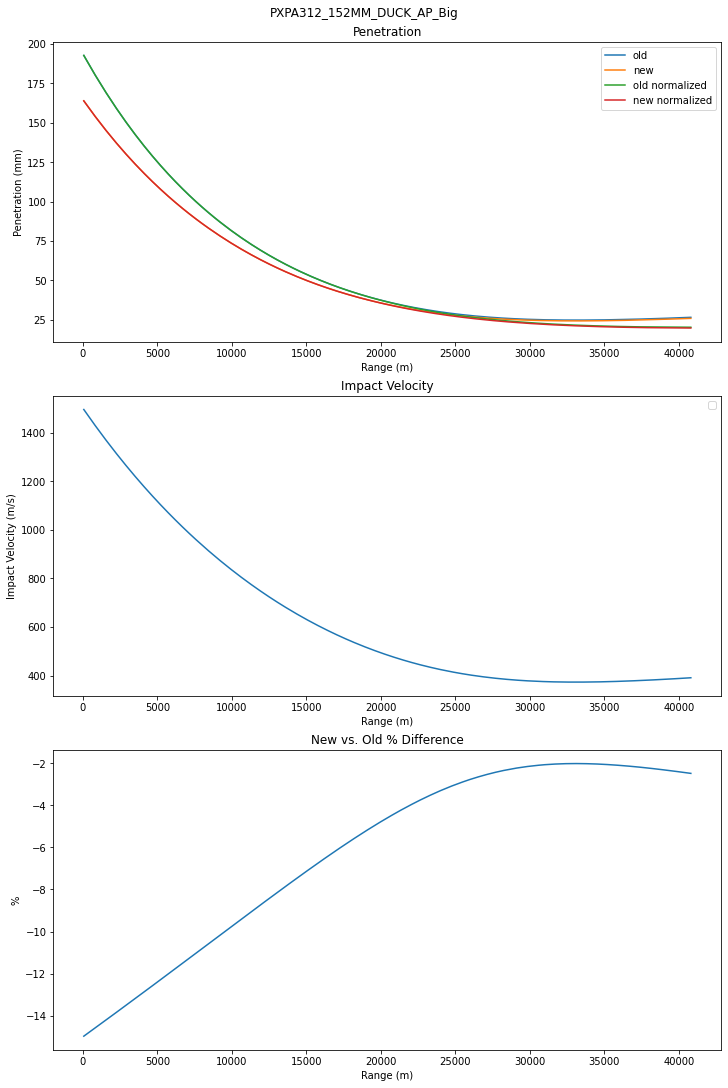

In [21]:
target = 'PXPA312_152MM_DUCK_AP_Big'
print(shells_ship_artillery[target])
plt.rcParams['figure.figsize'] = [10, 15]

fig, (ax0, ax1, ax2) = plt.subplots(3,1, constrained_layout=True)
fig.patch.set_facecolor('white')
fig.suptitle(target)

#ax.xaxis.set_major_locator(plt.MultipleLocator(1))

ax0.set_title('Penetration')
ax0.set_xlabel('Range (m)')
ax0.set_ylabel('Penetration (mm)')

ax1.set_title('Impact Velocity')
ax1.set_xlabel('Range (m)')
ax1.set_ylabel('Impact Velocity (m/s)')

ax2.set_title('New vs. Old % Difference')
ax2.set_xlabel('Range (m)')
ax2.set_ylabel('%')

target_impact_data = shell_impact_data[target]

ax0.plot(target_impact_data['distance'], target_impact_data['old_raw'], label='old')
ax0.plot(target_impact_data['distance'], target_impact_data['new_raw'], label='new')
ax0.plot(target_impact_data['distance'], target_impact_data['old_normalized'], label='old normalized')
ax0.plot(target_impact_data['distance'], target_impact_data['new_normalized'], label='new normalized')

ax1.plot(target_impact_data['distance'], target_impact_data['velocity'])
ax2.plot(target_impact_data['distance'], target_impact_data['difference'])

ax0.legend()
ax1.legend()
plt.show()